In [1]:
import numpy as np
from sklearn import decomposition, manifold
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import Input, models, Model as TFModel

from jarvis.utils.general import gpus, overload
from tfcaidm import Dataset, JClient, Model
from tfcaidm.models import registry, head

**Autoselect GPU (use only on caidm cluster)**

In [2]:
gpus.autoselect()

[ 2021-12-29 20:10:57 ] CUDA_VISIBLE_DEVICES automatically set to: 1           


In [3]:
!ls ./exp/adni/logs

2021-12-29_00-19-54_PST  2021-12-29_12-32-16_PST  2021-12-29_18-47-50_PST
2021-12-29_00-33-13_PST  2021-12-29_12-41-35_PST
2021-12-29_02-30-40_PST  2021-12-29_16-03-28_PST


## Model

In [4]:
import custom_losses as custom

In [5]:
class Path:
    base = "./exp/adni"
    run = base + "/logs/2021-12-29_16-03-28_PST"
    num = run + "/0"
    model = num + "/ae_0"
    pipeline = num + "/pipeline.yml"

In [6]:
model = models.load_model(Path.model, custom_objects={"ctr_loss": custom.ContrastiveLoss()})

## Visualize

In [7]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "iframe"

In [8]:
def get_model(model, layer_names=[]):
    return TFModel(inputs=model.inputs, outputs={name: model.get_layer(name).output for name in layer_names})

In [109]:
def plot_embeddings(true, pred, emb):
    fig = make_subplots(
        rows=1, cols=2, subplot_titles=("Model Prediction", "Ground-Truth"),
        specs=[[{"type": "scene"}, {"type": "scene"}]],
    )
    
    colorsIdx = {0: 'purple', 1: 'blue', 2:'green', 3: 'yellow', 4:'red'}
    colorsIdx = {0: 'purple', 1: 'yellow'}
    fig.add_trace(
        go.Scatter3d(
            x=emb[:, 0],
            y=emb[:, 1],
            z=emb[:, 2],
            mode="markers",
            marker=dict(color=[colorsIdx[i] for i in pred]),
        ),
        row=1,
        col=1,
    )
    
    colorsIdx = {0: 'purple', 1: 'yellow'}

    fig.add_trace(
        go.Scatter3d(
            x=emb[:, 0],
            y=emb[:, 1],
            z=emb[:, 2],
            mode="markers",
            marker=dict(color=[colorsIdx[i] for i in true]),
        ),
        row=1,
        col=2,
    )

    fig.update_layout(title_text="Lower-Dimensional Embedding Representations")
    fig.show()

### Embedding model

In [10]:
infer_model = get_model(model.layers[2], layer_names=["ctr", "cls"])

### Get embeddings

In [11]:
def get_embeddings(model):
    client = Dataset.from_yaml(Path.pipeline, fold=0)
    gen_train, gen_valid = client.create_generators(test=True)
    
    dat = []
    emb = []
    true = []
    pred = []

    for xs, ys in gen_valid:
        yh = model(xs["dat"])
        dat.append(xs["dat"])
        emb.append(yh["ctr"])
        pred.append(yh["cls"])
        true.append(xs["lbl"])

    dat = np.array(dat).squeeze()
    emb = np.array(emb).squeeze()
    true = np.array(true).squeeze()
    pred = np.array(pred).squeeze()
    
    return dat, emb, true, pred

**Lower-dimension visualizations**

In [12]:
dat, emb, true, pred = get_embeddings(infer_model)

[ 2021-12-29 20:12:13 ] [====================] 100.000% : Iterating | 000669    

In [13]:
print(classification_report(true, pred > 0.5))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       494
           1       0.77      0.79      0.78       175

    accuracy                           0.88       669
   macro avg       0.85      0.85      0.85       669
weighted avg       0.88      0.88      0.88       669



In [14]:
# emb3d = decomposition.PCA(n_components=3).fit_transform(emb)

In [15]:
# plot_embeddings(true.squeeze(), pred.squeeze() > 0.5, emb3d)

## Find model errors

In [16]:
class Binary:
    TN = 0 # 00
    FP = 1 # 01
    FN = 2 # 10
    TP = 3 # 11

In [17]:
unq = np.array([x + 2*y for x, y in zip(pred > 0.5, true)])

In [18]:
tn = np.array(np.where(unq == Binary.TN)).squeeze()
fp = np.array(np.where(unq == Binary.FP)).squeeze()
fn = np.array(np.where(unq == Binary.FN)).squeeze()
tp = np.array(np.where(unq == Binary.TP)).squeeze()

In [19]:
emb3d = decomposition.PCA(n_components=3).fit_transform(emb)

In [111]:
plot_embeddings(true.squeeze(), (pred > 0.5).squeeze(), emb3d)

More plots inside (hidden in this cell)

<!-- plot_embeddings(true.squeeze()[fn], (pred.squeeze() > 0.5)[fn]+Binary.FN, emb3d[fn])
plot_embeddings(true.squeeze()[fp], (pred.squeeze() > 0.5)[fp]*Binary.FP, emb3d[fp])
plot_embeddings(true.squeeze(), unq.squeeze(), emb3d) -->

### Nearest Neighbors

If two points of the same class are far away, that point is an outlier.

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [24]:
%%time

parameters = {
    'n_neighbors': range(5, 25, 5), 
    'p':[1, 2], 
    'weights': ['uniform', 'distance']
}

neigh = KNeighborsClassifier()
clf = GridSearchCV(neigh, parameters)
clf.fit(emb, true)

clf.best_score_, clf.best_params_ # I want to use distance so I will...

CPU times: user 12.2 s, sys: 22.4 s, total: 34.6 s
Wall time: 1.08 s


(0.8878689260464594, {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'})

**Train**

In [25]:
neigh = KNeighborsClassifier(n_neighbors=15, p=1, weights="distance")
neigh.fit(emb, true)

KNeighborsClassifier(n_neighbors=15, p=1, weights='distance')

In [26]:
neigh_graph = neigh.kneighbors_graph(emb, n_neighbors=len(emb), mode="distance")

In [27]:
neigh_graph.toarray()[fp].shape

(42, 669)

**Find outliers**

In [28]:
# --- Distance of false positives from true negatives
dist_fp = np.sum(neigh_graph.toarray()[fp][:, tn], axis=-1)
ind_fp = np.argsort(-dist_fp)
ind_fp # ordered from largest outlier to smallest

array([35,  6, 31,  5,  4, 18, 12,  8,  3, 34, 15, 17,  7, 25, 13, 28, 14,
       37, 10, 36, 27, 19, 29, 33,  9,  0, 23, 22, 40, 41, 24,  1, 20, 21,
       32, 26, 39, 16,  2, 30, 38, 11])

In [29]:
# --- Distance of false negatives from true positives
dist_fn = np.sum(neigh_graph.toarray()[fn][:, tp], axis=-1)
ind_fn = np.argsort(-dist_fn)
ind_fn # ordered from largest outlier to smallest

array([ 7,  9, 35,  5, 23, 22, 24, 33, 21, 32, 18, 20, 14, 10, 30, 11, 19,
        8, 17, 15, 34, 25, 16,  4, 12, 13, 36, 31, 26,  1,  0,  6, 28, 29,
        3,  2, 27])

**Retrieve problematic scans**

In [104]:
from jarvis.utils.display import imshow
from tfcaidm.models import viz

In [105]:
gc = viz.GradCAM(model.layers[2])

1. False positives (model thinks there's a disease but there isn't)

<Figure size 432x288 with 0 Axes>

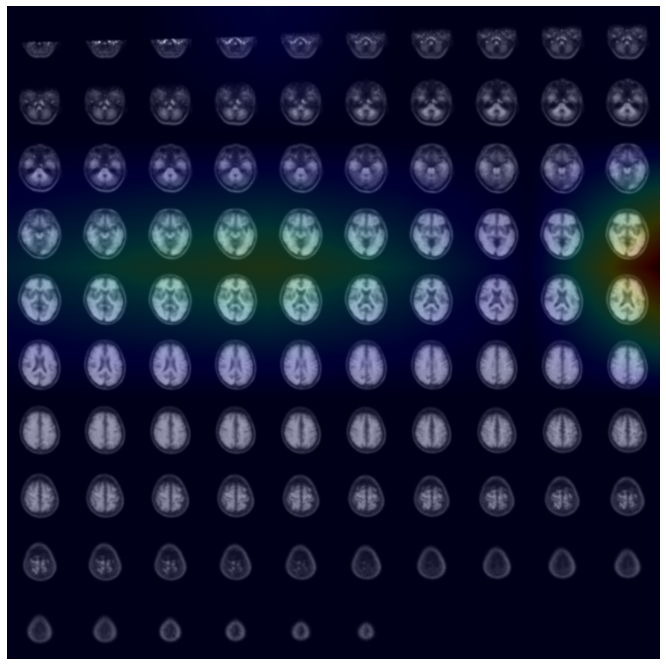

In [106]:
x = dat[ind_fp[0]][None, ...]

hm = gc.heatmap(x, layer=-5, output_name="cls", class_of_interest=0)
viz.overlay(x, hm.numpy(), figsize=(12, 12))

2. False negatives (model thinks there isn't a disease but there is)

<Figure size 432x288 with 0 Axes>

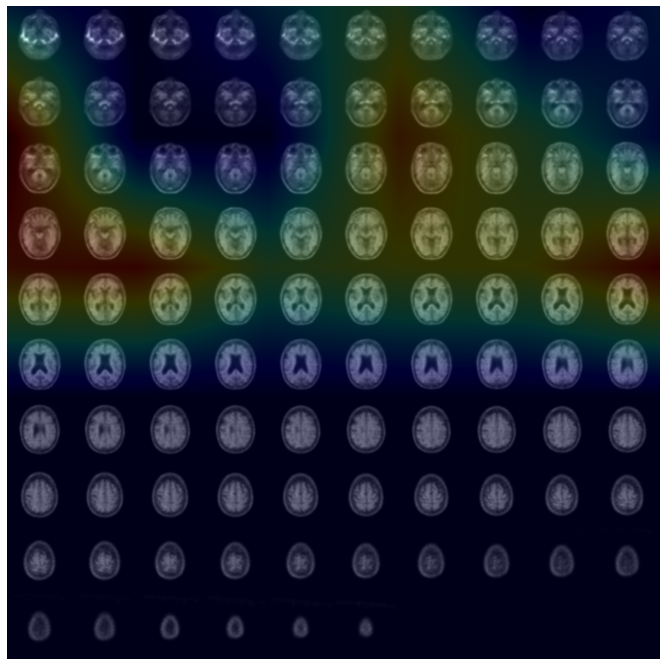

In [107]:
x = dat[ind_fn[0]][None, ...]

hm = gc.heatmap(x, layer=-5, output_name="cls", class_of_interest=0)
viz.overlay(x, hm.numpy(), figsize=(12, 12))